In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2022, 9, 24)

In [3]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,sp,sp_daily,sp_exp,nyse,nyse_daily,nyse_exp,nas,nas_daily,nas_exp,wil,wil_daily,wil_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2022-09-19,2022-09-19,3899.889893,1.006857,0.999972,14674.459961,1.006899,0.999837,11535.019531,1.007566,1.00048,39022.230469,1.007013,1.000128,1.000104,0
2022-09-20,2022-09-20,3855.929932,0.988728,0.999972,14474.719727,0.986389,0.999837,11425.049805,0.990466,1.00048,38558.480469,0.988116,1.000128,1.000104,0
2022-09-21,2022-09-21,3789.929932,0.982884,0.999972,14236.610352,0.983550,0.999837,11220.190430,0.982069,1.00048,37914.988281,0.983311,1.000128,1.000104,0
2022-09-22,2022-09-22,3757.989990,0.991572,0.999972,14116.589844,0.991570,0.999837,11066.809570,0.986330,1.00048,37483.148438,0.988610,1.000128,1.000104,0
2022-09-23,2022-09-23,3693.229980,0.982767,0.999972,13796.990234,0.977360,0.999837,10867.925781,0.982029,1.00048,36787.203125,0.981433,1.000128,1.000104,0


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ADBE', 'ADYEY', 'AMD', 'AMGN', 'AMZN',
    'ANET', 'ASML', 'AXON', 'BROS', 'BYND', 'CHWY', 'CRWD', 'DDOG',
    'DOCS', 'DOCU', 'DUOL', 'EDIT', 'ETSY', 'FLGT', 'GH', 'GMED',
    'GOOG', 'IDXX', 'INTG', 'ISRG', 'JD', 'LRCX', 'LSPD', 'LULU', 'MDB',
    'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 'NVDA', 'ODFL', 'OKTA',
    'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS', 'PYPL', 'QDEL', 'RBLX',
    'RDFN', 'RGEN', 'RIVN', 'ROKU', 'RVLV', 'SE', 'SHOP', 'SNOW',
    'TASK', 'TDOC', 'TEAM', 'TREX', 'TTD', 'TTWO', 'TWLO', 'TWTR',
    'TYL', 'UPST', 'VEEV', 'VLD', 'VRTX', 'XPEV', 'ZEN', 'ZM']
LINGERERS = [
    'AMEH', 'AMRK', 'BYRN', 'CIZN', 'CTSH', 'CUBE', 'EP', 'EXR', 'FCPT', 
    'FCUV', 'GBOX', 'GME', 'INTZ', 'KREF', 'LFMD', 'MCVT', 'MNMD',
    'OMQS', 'PETV', 'POWW', 'PRPH', 'RA', 'RVP', 'VIRT', 'WAVD', 'WKHS',
    'ZYXI']
BEST_WEIGHTED = [
    'ABST', 'APT', 'BKT', 'CEF', 'CFFN', 'CZFS', 'FCAP', 'FCN', 'FNV',
    'GCBC', 'HMY', 'IEI', 'MICS', 'MIY', 'MUJ', 'NAZ', 'NLY', 'NPV',
    'NXP', 'SOBR']
len(SYMBOLS)

73

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2012, 9, 26), datetime.date(2022, 9, 24))

In [6]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [7]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  120 of 120 completed


In [8]:
data['state'] = states.state
data.tail()

AdjClose                                                    \
                  AAPL        ABMD        ABNB   ABST        ADBE  ADYEY   
Date                                                                       
2022-09-19  154.479996  257.869995  118.779999  10.95  296.059998  13.12   
2022-09-20  156.899994  258.989990  116.709999  10.86  291.059998  12.68   
2022-09-21  153.720001  252.809998  114.010002  10.96  286.299988  12.65   
2022-09-22  152.740005  247.259995  103.720001  10.86  287.059998  12.50   
2022-09-23  150.429993  245.529999  101.750000  10.69  284.559998  12.19   

                                                         ...     Volume  \
                  AMD       AMEH        AMGN       AMRK  ...       VIRT   
Date                                                     ...              
2022-09-19  76.769997  39.000000  230.759995  25.770000  ...   870800.0   
2022-09-20  75.250000  39.139999  227.710007  24.059999  ...   806600.0   
2022-09-21  74.480003  41.709999  224.460007  24.430000  ...   668900.0   
2022-09-22  69.500000  40.580002  227.750000  25.850000  ...  4029400.0   
2022-09-23  67.959999  41.090000  226.970001  26.490000  ...  1746572.0   

                                                                        \
                  VLD     VRTX    WAVD     WKHS        XPEV        ZEN   
Date                                                                     
2022-09-19   916000.0  1350300   18500  2344200  18193100.0  4368600.0   
2022-09-20  1013100.0  1130600   30800  1638800  15856000.0  2937400.0   
2022-09-21  1275300.0  1109800   13500  2639100  41645500.0  2268600.0   
2022-09-22  3079400.0  1408200  188400  2658000  23489400.0  3947200.0   
2022-09-23  1255101.0  1321120   85490  3605350  28105835.0  4305810.0   

                              state  
                   ZM    ZYXI        
Date                                 
2022-09-19  4515000.0  189800     0  
2022-09-20  3157800.0  113900     0  
2022-09-21  3274100.0  128300     0  
2022-09-22  4116200.0  133400     0  
2022-09-23  3889982.0  156832     0  

[5 rows x 721 columns]

In [9]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [10]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

0

In [11]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [12]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [13]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [14]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [15]:
def get_weighted_sharpe(daily_returns, data, weights=[0.2, 0.6, 0.2]):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return (
        weights[0]*lower_state_sharpe
        + weights[1]*state_sharpe
        + weights[2]*upper_state_sharpe)

In [16]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [17]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [18]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [19]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [20]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [21]:
EXAMPLE = 'AAPL'

In [22]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.8388346537019594, -1.4841637912426364)

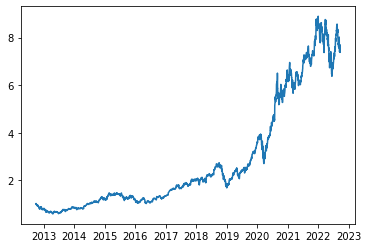

In [23]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

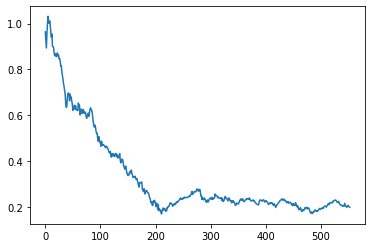

In [24]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [25]:
get_weighted_sharpe(daily_returns, data.copy())

-0.712846632868841

In [26]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    n_notnull_resid = stock_data.resid.notnull().sum()
    stock_data['dev'] = np.nan
    stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
        np.array(range(n_notnull_resid) / n_notnull_resid))
    stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],
        stock_data.rsi.tolist()[-1],
        stock_data.resid.tolist()[-1], 
        stock_data.dev.tolist()[-1],
        stock_data.drawdown.tolist()[-1],
        stock_data.pullup.tolist()[-1],
        sharpe,
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)

(0,
 0.13514594162335067,
 0.5113320079522863,
 0.5113320079522863,
 0.15558343789209536,
 0.2722710163111669,
 0.8388346537019594,
 -0.712846632868841)

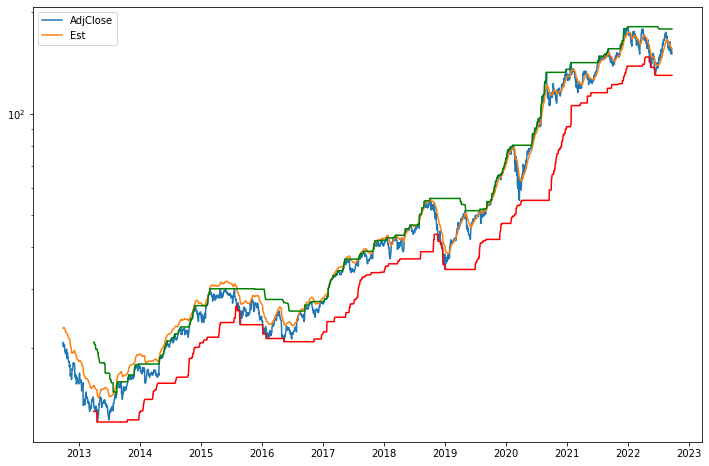

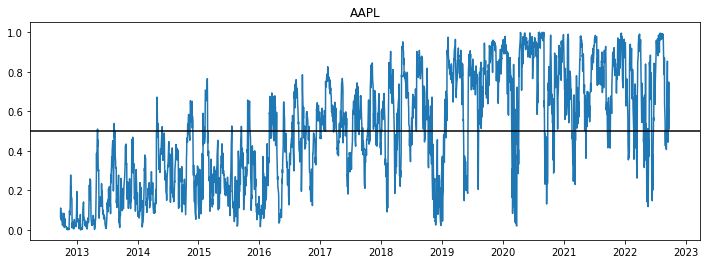

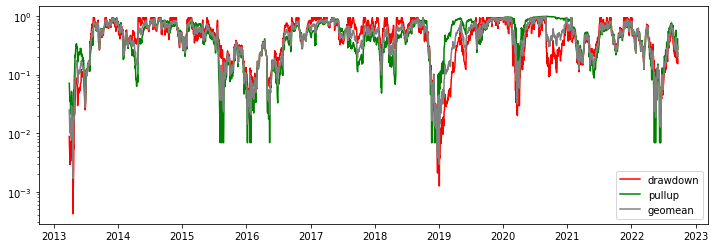

In [27]:
process_stock('AAPL', data.copy(), plot=True)

In [28]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ABST... ADBE... ADYEY... AMD... AMEH... AMGN... AMRK... AMZN... ANET... APT... ASML... AXON... BKT... BROS... BYND... BYRN... CEF... CFFN... CHWY... CIZN... CRWD... CTSH... CUBE... CZFS... DDOG... DOCS... DOCU... DUOL... EDIT... EP... ETSY... EXR... FCAP... FCN... FCPT... FCUV... FLGT... FNV... GBOX... GCBC... GH... GME... GMED... GOOG... HMY... IDXX... IEI... INTG... INTZ... ISRG... JD... KREF... LFMD... LRCX... LSPD... LULU... MCVT... MDB... MELI... MICS... MIY... MNMD... MNST... MSFT... MTCH... MUJ... NAZ... NLY... NPV... NVCR... NVDA... NXP... ODFL... OKTA... OMQS... OPEN... PAC... PANW... PAYC... PETV... PINS... POWW... PRPH... PYPL... QDEL... RA... RBLX... RDFN... RGEN... RIVN... ROKU... RVLV... RVP... SE... SHOP... SNOW... SOBR... TASK... TDOC... TEAM... TREX... TTD... TTWO... TWLO... TWTR... TYL... UPST... VEEV... VIRT... VLD... VRTX... WAVD... WKHS... XPEV... ZEN... ZM... ZYXI... 

In [29]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult', 'dev_quantile',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df.dev_quantile
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'dev_quantile', 'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,dev_quantile,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,0,0.135146,0.864854,0.511332,0.511332,0.155583,0.272271,0.205818,0.324409,0.838835,-0.712847
1,ABMD,0,0.057977,0.942023,0.086282,0.086282,0.132581,0.143455,0.137910,0.109084,0.775957,-0.846246
2,ABNB,0,0.064220,0.935780,0.031111,0.031111,0.107362,0.365031,0.197966,0.078479,-0.054093,-0.187097
3,ABST,0,0.437425,0.562575,0.854473,0.854473,0.388331,0.917399,0.596871,0.714150,0.494617,0.461129
4,ADBE,0,0.000800,0.999200,0.004771,0.004771,0.012965,0.008365,0.010414,0.007049,0.856633,-1.063089


In [30]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.009294
0.99    0.826563
Name: geomean, dtype: float64

In [31]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [32]:
!open individ_quantiles.csv